In [4]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import math
import cmath
import scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.special as special
import numpy.ma as ma
import matplotlib.scale as mscale
from scipy.linalg import eigvalsh
#np.set_printoptions(threshold=sys.maxsize)
pts = 5000 # number of iterator steps
H_to_K = 1/0.000003166808534191
tol = 1e-6

In [5]:
C12 = 3.05e8 #C12 coefficient in Eh*ao
C6 = 4710 #C6 coefficient in Eh*ao
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb)

# $V(r) = \frac{C_{12}}{r^{12}} - \frac{C_{6}}{r^{6}}$
## $C_{12} = 8.55\times10^{7} E_{h}a_{0}$, $C_{6} = 6710 E_{h}a_{0}$

-0.018183674629667836


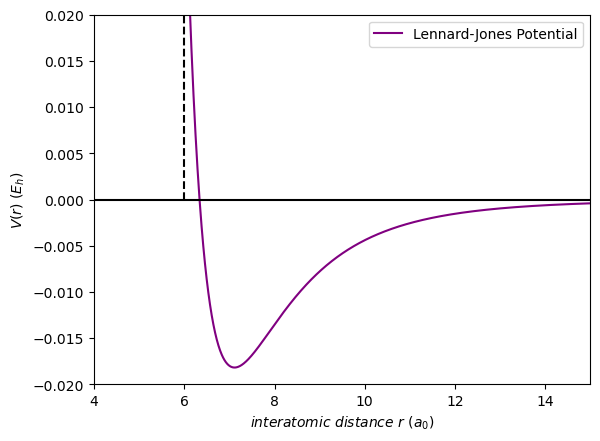

In [7]:
Npts = 7500
r = np.linspace(4,60, Npts) # range of r values to iterate over, 4 -> 60 Bohr radii
#r_pot = np.linspace(4,60, N) # range of r values to iterate over, ~0 -> 60 Bohr radii
psi = np.zeros(Npts)

Vr = (C12/(r**12)) - (C6/(r**6))



plt.plot(r, Vr, label = 'Lennard-Jones Potential', color = 'purple')
plt.hlines(0,0, max(r), color = 'black')
plt.vlines(6, 0, max(r), color = 'black', linestyle = 'dashed')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{0})$')
plt.ylabel('$V(r)$ $(E_{h})$')
plt.ylim(-0.02, 0.02)
plt.xlim(4,15)
plt.legend()

print(min(Vr))
#plt.vlines(6.375,-0.02,0.02)
#plt.vlines(11.04,-0.02,0.02)

# LJ DVR

## $ x \in (a,b) $, $x_{i} = a + \frac{(b-a)i}{N}, i = 1,2,..,N-1$, $dx = \frac{(b-a)}{N}$
# $ T_{ij} = \frac{1}{2} \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{2} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $
# $ T_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}]$
# $ V_{ii} = \frac{C_{12}}{r_{i}^{12}} - \frac{C_{6}}{r_{i}^6}$

# $H_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4 \mu} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}] + \frac{C_{12}}{r_{i}^{12}} - \frac{C_{6}}{r_{i}^6} $
# $ H_{ij} = \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{4\mu} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $

In [31]:
def Hamiltonian_DVR(a, b, dx):
    N = int((b-a)/dx) # Number of grid points
    ipaper = np.arange(1,N, 1.0) # indexing from the paper, given i = 1,2,...,N-1
    x = a + dx*ipaper # grid from paper
    Vx = C12/(x**12) - C6/(x**6)
    Vx = np.insert(Vx,0,0)

    #print(f' ipaper = {ipaper}')
    #print(f' x = {x}')
    print(f' N - 1 = {N-1}')
    #print(f' len(x) = {len(x)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {x[1] - x[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N-1 x N-1
    Vmat = np.zeros((len(x) + 10, len(x) + 10))
    Tmat = np.zeros((len(x) + 10, len(x) + 10))


    for i in ipaper:
        for j in ipaper:
            if int(i) == int(j): # fill in diagonal components of the Hamiltonian
                prefactorii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                
                Tmat[int(i)][int(j)] = prefactorii*bracketii
                Vmat[int(i)][int(j)] = Vx[int(j)]
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)] + Vmat[int(i)][int(j)]
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                diff = i - j
                prefactorij = ((-1)**(diff))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((diff)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                Tmat[int(i)][int(j)] = prefactorij*bracketij               
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)]
                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')
    return H_DVR

In [58]:
a1 = 4.5
b1 = 20
dx1 = 0.005

N1 = int((b1-a1)/dx1) # Number of grid points
ipap = np.arange(1,N1, 1.0) # indexing from the paper, given i = 1,2,...,N-1
x1 = a1 + dx1*ipap


VLJ = C12/(x1**12) - C6/(x1**6)
Vmin = min(VLJ)

H = Hamiltonian_DVR(a1, b1, dx1)

 N - 1 = 3099


In [59]:
Heig = np.linalg.eigh(H)[0]
Eigvec = np.linalg.eigh(H)[1]
Hvec = []
for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)
for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,x1)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]


#Hneg = Heig[Heig<0]
#print(f' len(Hneg) = {len(Hneg)}')
#print(f' Hneg[-1] = {Hneg[-1]}')
#for i in range(len(Hvec)):
#    Norm = np.trapz(np.abs(Hvec[i])**2,x1)
#    assert( abs(Norm - 1) < tol)
#print(np.trapz(np.abs(Hvec[0])**2,x1))
#for i in range(len(Hvec)):
   # Hvec[i] = np.abs(Hvec[i])**2

-0.0173319846094129


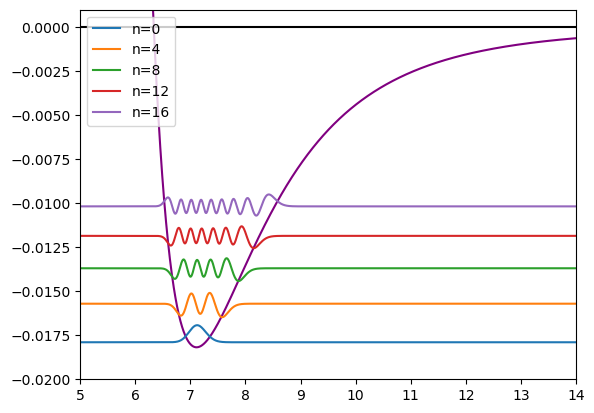

In [96]:
print(Heig[1])
plt.hlines(0,min(x1), max(x1), color = 'black')
plt.plot(x1, VLJ, color = 'purple')
for i in range(20):
    if i % 4 == 0:
        plt.plot(x1, 0.0005*Hvec[i] + Heig[i], label = f'n={i}')

plt.ylim(-0.02, 0.001)
plt.xlim(5,14)
plt.legend()

# NEXT GOAL
## Find how many bound states there are, energies and such
## Convergence wrt b

In [ ]:
small_diff = []
for i in range(len(H[0])):
    Hnvecn = np.matmul(H, Hvec[i])
    Envecn = Heig[i]*Hvec[i]
    diff  = np.abs(Hnvecn - Envecn)
    max_diff = max(diff)
    if max_diff < tol:
        small_diff.append(i)

In [ ]:
print(len(small_diff))

In [ ]:
Hneg = Heig[Heig > Vmin]

Hwell = Hneg[Hneg < 0]

print(len(Hwell))

#print(Hwell[0:10] - Heig[0:10])

wellvec = []

for i in range(len(Hwell)):
    for j in range(len(Heig)):
        if Hwell[i] == Heig[j]:
            wellvec.append(Hvec[i])

print(len(wellvec))

In [64]:
print(Hneg)

[-1.78968422e-02 -1.73319846e-02 -1.67785355e-02 -1.62364034e-02
 -1.57054962e-02 -1.51857211e-02 -1.46769848e-02 -1.41791932e-02
 -1.36922515e-02 -1.32160643e-02 -1.27505355e-02 -1.22955684e-02
 -1.18510653e-02 -1.14169281e-02 -1.09930579e-02 -1.05793549e-02
 -1.01757187e-02 -9.78204815e-03 -9.39824132e-03 -9.02419548e-03
 -8.65980717e-03 -8.30497209e-03 -7.95958519e-03 -7.62354058e-03
 -7.29673157e-03 -6.97905064e-03 -6.67038942e-03 -6.37063871e-03
 -6.07968847e-03 -5.79742776e-03 -5.52374478e-03 -5.25852687e-03
 -5.00166045e-03 -4.75303105e-03 -4.51252328e-03 -4.28002084e-03
 -4.05540651e-03 -3.83856211e-03 -3.62936852e-03 -3.42770567e-03
 -3.23345255e-03 -3.04648713e-03 -2.86668646e-03 -2.69392657e-03
 -2.52808250e-03 -2.36902831e-03 -2.21663703e-03 -2.07078068e-03
 -1.93133027e-03 -1.79815577e-03 -1.67112612e-03 -1.55010924e-03
 -1.43497203e-03 -1.32558034e-03 -1.22179900e-03 -1.12349179e-03
 -1.03052149e-03 -9.42749800e-04 -8.60037419e-04 -7.82243994e-04
 -7.09228139e-04 -6.40847

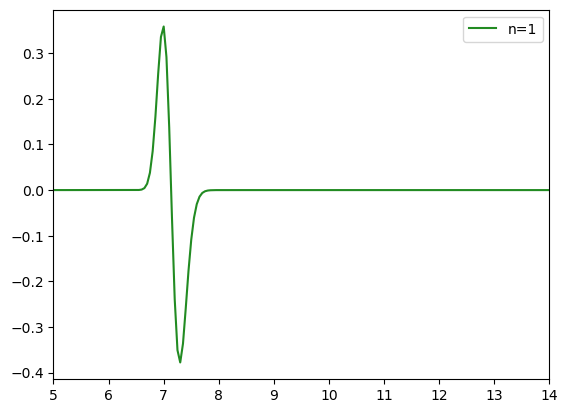

In [60]:
for i in range(len(Hvec)):
    if i == 1:
        plt.plot(x1, Hvec[i], color = 'forestgreen', label = f'n={i}')

plt.xlim(5,14)
plt.legend()

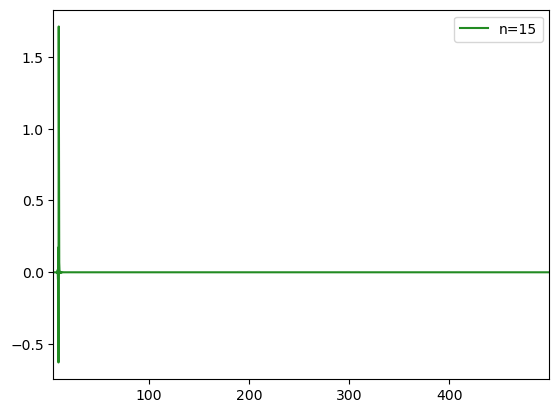

In [14]:
for i in range(len(Hvec)):
    if i == 15:
        plt.plot(x1, Hvec[i], color = 'forestgreen', label = f'n={i}')

plt.xlim(5,max(x1))
plt.legend()

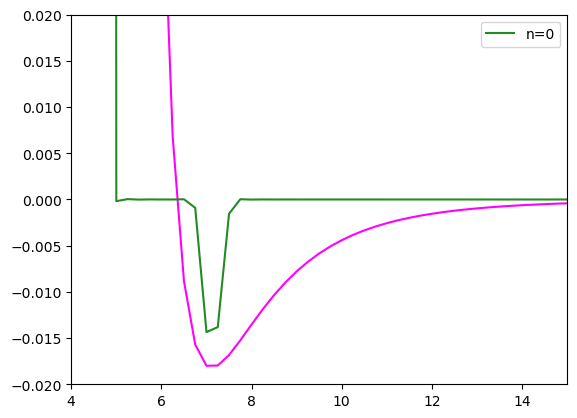

In [15]:

plt.plot(x1, VLJ, color = 'fuchsia')
for i in range(len(Hvec)):
    if i == 0:
        plt.plot(x1, 0.01*Hvec[i] + H[i], color = 'forestgreen', label = f'n={i}')


plt.ylim(-0.02, 0.02)
plt.xlim(4,15)
plt.legend()

In [16]:
np.set_printoptions(threshold=np.inf)
Hneg = Heig[Heig > Vmin]

Hwell = Hneg[Hneg < 0]

#print(len(Hwell))

#print(Hwell[0:10] - Heig[0:10])

wellvec = []

for i in range(len(Hwell)):
    for j in range(len(Heig)):
        if Hwell[i] == Heig[j]:
            wellvec.append(Hvec[i])

#print(f' Well eigvals = {Hwell[0:10]}')

print(Vmin)
#print(f' Eigvals = {Heig}')

#print(f' Vmin = {Vmin}Eh')

#print(Heig[-1])

for i in range(len(Heig)):
    if Heig[i] == Hwell[0]:
        print(i)
        break


print(Vmin - Heig[0])

-0.017998816611651636
0
-0.00013266701553995772


In [17]:
iuqchn983c3r 

NameError: name 'iuqchn983c3r' is not defined

In [ ]:
#b_range = np.linspace(14, 500, 20)

En = [ [] for i in range(51) ]

for i in range(len(b_range)):
    Hb = Hamiltonian_DVR(a1 + dx1, b_range[i] - dx1, dx1)
    Hbeig = np.linalg.eigh(Hb)[0]
    Es = Hbeig[0:51]
    for j in range(51):
        En[i].append(Es[j])
    if i == int(len(b_range)/2):
        print('halfway there')
    if i == int(8*(len(b_range)/9)):
        print('almost there')

In [ ]:
print(En)

In [ ]:
for i in range(len(En)):
    if i == 18:
        if len(En[i]) != 0:
            plt.plot(b_range, En[i][0:len(b_range)], label = f'n={i}', color = 'goldenrod')

plt.legend()

In [ ]:
def Hamiltonian_DVR(a, b, dx):
    N = int((b-a)/dx) # Number of grid points
    print(f' N = {N}')
    x = np.linspace(a + dx,b - dx, N - 1) # grid

    #Vx = C12/(x**12) - C6/(x**6)
    #Vxmin = abs(min(VLJ))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N x N

    for i in range(1, N):
        for j in range(1, N):
            if i == j: # fill in diagonal components of the Hamiltonian
                prefacii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                Vii = 102*(4343/(x[i - 1]**12) - 650/(x[i - 1]**6)) + 33/(x[i - 1]**2)
                
                H_DVR[i - 1][j - 1] = prefacii*bracketii + Vii
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                prefacij = (-1**(i-j))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((i-j)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                
                H_DVR[i - 1][j - 1] = prefacij*bracketij
                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))

    return H_DVR




In [ ]:
y = np.linspace(1,10,500)
Wcc = 102*(4343/(y**12) - 650/(y**6)) + 33/(y**2)

plt.plot(y, Wcc, color = 'orange')
print(min(Wcc))


plt.ylim(-2500,100)

In [ ]:
dx2 = 0.001
a2 = 1
b2 = 10
H2 = Hamiltonian_DVR(a2,b2,dx2)

In [ ]:
H2eig = np.linalg.eigh(H2)[0]
yp = np.linspace(a2, b2, int((b2-a2)/dx2 - 1))
vecs = np.linalg.eigh(H2)[1]
H2vec = []

for i in range(len(H2[0])):
    H2vec.append(vecs[:,i])

for i in range(len(H2vec)):
    INT = np.trapz(np.abs(H2vec[i])**2, yp)
    A = 1/np.sqrt(INT)
    H2vec[i] *= A

print(np.trapz(np.abs(H2vec[5])**2, yp))


In [ ]:
print(f' standard eigval = {H2eig[0:5]}')
print(f' numpy 2 eigval = {H2eigp[0:5]}')
print(f' scipy eigval = {H2eigpp[0:5]}')
print(min(Wcc))

In [ ]:
yp = np.linspace(a2, b2, int((b2-a2)/dx2 - 1))
plt.plot(y, Wcc, color = 'goldenrod')
for i in range(len(Heig)):
    if i == 7:
        plt.plot(yp, np.abs(H2vec[i])**2 + H2eig[i], color = 'aqua')
plt.xlim(1.45,1.6)
plt.ylim(-2500,-2400)